In [27]:
import os
from datetime import timedelta

import numpy as np
import pandas as pd
import pickle
import featuretools as ft
from featuretools.selection import remove_low_information_features, \
    remove_highly_correlated_features, remove_highly_null_features

In [28]:
ROOT = os.path.abspath('../')
# PIC_dir = os.path.join(ROOT, 'data/raw/PIC/')
PIC_dir = os.path.join(ROOT, 'data/raw/PIC_mini/')
output_dir = os.path.join(ROOT, 'data/intermediate/')

## 1. Entityset Generation
---

In [29]:
def save_entityset(entityset):  # saves a serialized entity set in output_dir/entityset
    with open(os.path.join(output_dir, 'entityset'), 'wb') as f:
        pickle.dump(entityset, f)
        
def load_entityset(): # loads a serialized entiy set
    with open(os.path.join(output_dir, 'entityset'), 'rb') as f:
        return pickle.load(f)
    
def save_fm(df, fm_list, token=''):  # saves a fm_list both as a pickle and a csv
    if str(token) != '':
        token = '_' + str(token)
    with open(os.path.join(output_dir, 'fl{}.pkl'.format(token)), 'wb') as f:
        pickle.dump(fm_list, f)
    df.to_csv(os.path.join(output_dir, 'fm{}.csv'.format(token)))
    
def load_fm(token=None): # loads an fm_list both as an object and a DataFrame
    if str(token) != '':
        token = '_' + str(token)
    with open(os.path.join(output_dir, 'fl{}.pkl'.format(token)), 'rb') as f:
        fm_list = pickle.load(f)
    df = pd.read_csv(os.path.join(output_dir, 'fm{}.pkl'.format(token)), index_col=0)
    return df, fm_list

In [30]:
RELATIONSHIPS = [
    # PATIENTS
    ('PATIENTS', 'SUBJECT_ID', 'ADMISSIONS', 'SUBJECT_ID'),
    ('PATIENTS', 'SUBJECT_ID', 'PRESCRIPTIONS', 'SUBJECT_ID'),
    # ADMISSIONS
    ('ADMISSIONS', 'HADM_ID', 'ICUSTAYS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'DIAGNOSES_ICD', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'EMR_SYMPTOMS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'LABEVENTS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'MICROBIOLOGYEVENTS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'OR_EXAM_REPORTS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'SURGERY_INFO', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'CHARTEVENTS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'OUTPUTEVENTS', 'HADM_ID'),
    ('ADMISSIONS', 'HADM_ID', 'PRESCRIPTIONS', 'HADM_ID'),
    # SURGERYS
    ('SURGERY_INFO', 'UNI_OPER_ID', 'SURGERY_VITAL_SIGNS', 'UNI_OPER_ID'),
    # ICUSTAYS
    ('ICUSTAYS', 'ICUSTAY_ID', 'INPUTEVENTS', 'ICUSTAY_ID'),
#     ('ICUSTAYS', 'ICUSTAY_ID', 'CHARTEVENTS', 'ICUSTAY_ID'),
#     ('ICUSTAYS', 'ICUSTAY_ID', 'OUTPUTEVENTS', 'ICUSTAY_ID'),
#     ('ICUSTAYS', 'ICUSTAY_ID', 'PRESCRIPTIONS', 'ICUSTAY_ID'),
    # DICTS
    ('D_ITEMS', 'ITEMID', 'CHARTEVENTS', 'ITEMID'),
    ('D_ITEMS', 'ITEMID', 'OUTPUTEVENTS', 'ITEMID'),
    ('D_ITEMS', 'ITEMID', 'MICROBIOLOGYEVENTS', 'SPEC_ITEMID'),
    ('D_ITEMS', 'ITEMID', 'MICROBIOLOGYEVENTS', 'ORG_ITEMID'),
    ('D_ITEMS', 'ITEMID', 'MICROBIOLOGYEVENTS', 'AB_ITEMID'),
    ('D_ITEMS', 'ITEMID', 'SURGERY_VITAL_SIGNS', 'ITEMID'),
    ('D_LABITEMS', 'ITEMID', 'LABEVENTS', 'ITEMID'),
    ('D_ICD_DIAGNOSES', 'ICD10_CODE_CN', 'DIAGNOSES_ICD', 'ICD10_CODE_CN'),
]

In [31]:
META_INFO = {
    'PATIENTS': {
        'index': 'SUBJECT_ID',
        'types': {'SUBJECT_ID': 'int', 'EXPIRE_FLAG': 'bool'},
#         'secondary_index': {
#             'DOB': ['EXPIRE_FLAG'],
#             'DOD': ['EXPIRE_FLAG'],
#         }
    },
    'ADMISSIONS': {
        'index': 'HADM_ID',
        'foreign_index': ['SUBJECT_ID'],
        'types': {'SUBJECT_ID': 'int', 'HADM_ID': 'int'},
        'time_index': 'ADMITTIME',
        'secondary_index': {
            'DISCHTIME': ['DISCHARGE_DEPARTMENT', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'EDOUTTIME'],
            'DEATHTIME': ['DISCHARGE_DEPARTMENT', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'EDOUTTIME'],
        },
    },
    'ICUSTAYS': {
        'index': 'ICUSTAY_ID',
        'foreign_index': ['SUBJECT_ID', 'HADM_ID'],
        'types': {'HADM_ID': 'int', 'ICUSTAY_ID': 'int', 'FIRST_WARDID': 'str', 
                  'LAST_WARDID': 'str'},
        'time_index': 'INTIME',
        'secondary_index': {
            'OUTTIME': ['LAST_CAREUNIT', 'LAST_WARDID', 'LOS']
        }
    },
    'SURGERY_INFO': {
        'index': 'UNI_OPER_ID',
        'foreign_index': ['SUBJECT_ID', 'HADM_ID'],
        'types': {'HADM_ID': 'int', 'VISIT_ID': 'str', 'OPER_ID': 'str'},
        'time_index': 'ANES_START_TIME',
        'secondary_index': {
            'ANES_END_TIME': [],
            'SURGERY_BEGIN_TIME': [],
            'SURGERY_END_TIME': []
        }
    },
    'DIAGNOSES_ICD': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'ICD10_CODE_CN'],
        'types': {'ICD10_CODE_CN': 'str', 'HADM_ID': 'int'},
    },
    'SURGERY_VITAL_SIGNS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'OPER_ID'],
        'types': {'HADM_ID': 'int', 'ITEMID': 'str', 'VISIT_ID': 'int', 
                  'OPER_ID': 'int', 'ITEM_NO': 'int'},
        'time_index': 'MONITOR_TIME',
    },
    'EMR_SYMPTOMS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'EMR_ID'],
        'types': {'HADM_ID': 'int'},
        'time_index': 'RECORDTIME',
    },
    'LABEVENTS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'ITEMID'],
        'types': {'HADM_ID': 'int', 'ITEMID': 'str'},
        'time_index': 'CHARTTIME'
    },
    'MICROBIOLOGYEVENTS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'SPEC_ITEMID', 'ORG_ITEMID', 'AB_ITEMID'],
        'types': {'HADM_ID': 'int', 'SPEC_ITEMID': 'str', 
                  'ORG_ITEMID': 'str', 'AB_ITEMID': 'str'},
        'time_index': 'CHARTTIME'
    },
    'OR_EXAM_REPORTS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID'],
        'types': {'HADM_ID': 'int'},
        'time_index': 'REPORTTIME'
    },
    'CHARTEVENTS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'ITEMID'],
        'types': {'ITEMID': 'str'},
        'time_index': 'CHARTTIME'
    },
    'INPUTEVENTS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
        'types': {'ICUSTAY_ID': 'int'},
        'time_index': 'CHARTTIME'
    },
    'OUTPUTEVENTS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID', 'ITEMID'],
        'types': {'ITEMID': 'str'},
        'time_index': 'CHARTTIME'
    },
    'PRESCRIPTIONS': {
        'foreign_index': ['SUBJECT_ID', 'HADM_ID'],
        'time_index': 'STARTDATE',
        'secondary_index': {
            'ENDDATE': []
        }
    },
    'D_ITEMS': {
        'index': 'ITEMID',
        'types': {'ITEMID': 'str'},
    },
    'D_LABITEMS': {
        'index': 'ITEMID',
        'types': {'ITEMID': 'str'},
    },
    'D_ICD_DIAGNOSES': {
        'index': 'ICD10_CODE_CN',
        'types': {'ICD10_CODE_CN': 'str'},
    }
}

In [32]:
def remove_nan_entries(df, key_columns, verbose=True):
    n_row = len(df)
    for column in key_columns:
        df = df[df[column] == df[column]]
    if verbose:
        print("Prune ({}/{}) rows.".format(n_row-len(df), n_row))
    return df

In [33]:
def load_pic(save=True):
    
    es = ft.EntitySet(id="pic")

    for table_name, info in META_INFO.items(): # Iterate through entries in the META_INFO defined above, which includes tables names and various index types

        table_df = pd.read_csv(os.path.join(PIC_dir, '{}.csv'.format(table_name)),
                               date_parser=pd.to_datetime)
        
        if table_name in ['SURGERY_INFO', 'SURGERY_VITAL_SIGNS']:
            table_df['UNI_OPER_ID'] = (table_df['HADM_ID'] - 100000)*64 + table_df['VISIT_ID']*8 + table_df['OPER_ID']
            
        if table_name == 'SURGERY_INFO':
            table_df = table_df[~table_df['UNI_OPER_ID'].duplicated()]

        index = info.get('index', 'ROW_ID')
        index_columns = info.get('foreign_index', [])+[index]
        table_df = remove_nan_entries(table_df, index_columns)

        for col, t in info.get('types', {}).items():
            table_df[col] = table_df[col].astype(t)

        es.entity_from_dataframe(entity_id=table_name,
                                 dataframe=table_df,
                                 index=index,
                                 time_index=info.get('time_index', None),
                                 secondary_time_index=info.get('secondary_index', None))
    
    for parent, primary_key, child, foreign_key in RELATIONSHIPS:
        new_relationship = ft.Relationship(es[parent][primary_key], es[child][foreign_key])

        es = es.add_relationship(new_relationship)
        
    if save:
        save_entityset(es)
        
    return es

In [34]:
es = load_pic()

Prune (0/1934) rows.
Prune (0/1996) rows.
Prune (0/2108) rows.
Prune (0/1975) rows.
Prune (0/3778) rows.
Prune (0/754213) rows.
Prune (0/75981) rows.
Prune (0/1724805) rows.
Prune (12106/29547) rows.
Prune (0/39872) rows.
Prune (0/450989) rows.
Prune (253/2837) rows.
Prune (0/7849) rows.
Prune (0/171332) rows.
Prune (0/479) rows.
Prune (0/832) rows.
Prune (0/25379) rows.


## 2. Feature Generation
---

In [35]:
es = load_entityset()

# 19 distinct items in total
chart_event_items = es['CHARTEVENTS'].df['ITEMID'].unique()

# select frequent lab test items, 18 among 821
lab_count = es['LABEVENTS'].df['ITEMID'].value_counts()
lab_test_items = lab_count[lab_count > 40000].index

# 6 distinct items in total
vital_sign_items = es['SURGERY_VITAL_SIGNS'].df['ITEMID'].unique()

# select 25 frequent symptoms, 
emr_count = es['EMR_SYMPTOMS'].df['SYMPTOM_NAME'].value_counts()
emr_items = emr_count[emr_count > 800].index

# select 26 frequent prescriptions
prescription_items = es["PRESCRIPTIONS"].df['DRUG_NAME_EN'].value_counts()
prescription_items = prescription_items[prescription_items > 1500]

es['CHARTEVENTS']['ITEMID'].interesting_values = chart_event_items
es['LABEVENTS']['ITEMID'].interesting_values = lab_test_items
es['SURGERY_VITAL_SIGNS']['ITEMID'].interesting_values = vital_sign_items
es['EMR_SYMPTOMS']['SYMPTOM_NAME'].interesting_values = emr_items
es['PRESCRIPTIONS']['DRUG_NAME_EN'].interesting_values = prescription_items

# add last time indexes
es.add_last_time_indexes()

In [36]:
ignore_variables = {
    'PATIENTS': ['ROW_ID', 'EXPIRE_FLAG', 'DOD', 'SUBJECT_ID'],
    'ADMISSIONS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID'],
    'ICUSTAYS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'SUBJECT_ID'],
    'SURGERY_INFO': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'VISIT_ID', 'OPER_ID'],
    'DIAGNOSES_ICD': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID'],
    'SURGERY_VITAL_SIGNS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'VISIT_ID', 'OPER_ID', 'ITEM_NO'],
    'EMR_SYMPTOMS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'EMR_ID', 'SYMPTOM_NAME_CN'],
    'LABEVENTS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'VALUEUOM', 'CHARTTIME'],
    'MICROBIOLOGYEVENTS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'AB_ITEMID', 'ORG_ITEMID', 'SPEC_ITEMID'],
    'OR_EXAM_REPORTS': ['ROW_ID', 'HADM_ID', 'SUBJECT_ID', 'REPORTTIME'],
    'CHARTEVENTS': ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'VALUEUOM', 'STORETIME'],
    'INPUTEVENTS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'SUBJECT_ID'],
    'OUTPUTEVENTS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'SUBJECT_ID'],
    'PRESCRIPTIONS': ['ROW_ID', 'HADM_ID', 'ICUSTAY_ID', 'SUBJECT_ID', 'DOSE_UNIT_RX', 'PROD_STRENGTH', 
                      'DRUG_NAME_GENERIC', 'DOSE_UNIT_RX', 'DRUG_FORM', 'DRUG_NAME'],
    'D_ITEMS': ['ROW_ID', 'ITEMID', 'UNITNAME', 'LINKSTO', 'LABEL_CN', 'CATEGORY'],
    'D_LABITEMS': ['ROW_ID', 'ITEMID', 'LABEL_CN'],
    'D_ICD_DIAGNOSES': ['ROW_ID']
}

In [37]:
def select_features(fm, fl=None):
    fm = remove_highly_null_features(fm)
    fm = remove_low_information_features(fm)
#     fm = remove_highly_correlated_features(fm)
    if fl is None:
        return fm
    else:
        fl = [f for f in fl if f._name in fm.columns]
        return fm, fl

In [38]:
# Define pc problem
target_entity = 'SURGERY_INFO'
label_times = es['SURGERY_INFO'].df[['UNI_OPER_ID', 'SURGERY_END_TIME']]
label_times.columns = ['instance_id', 'time']

# Generate features
feature_matrix, features_list = ft.dfs(entityset=es,
                                       target_entity=target_entity,
                                       agg_primitives=["std", "mean", "trend"],
                                       where_primitives=["mean", "std", "trend"],
                                       trans_primitives=[],
                                       allowed_paths=[['SURGERY_INFO', 'SURGERY_VITAL_SIGNS']],
                                       ignore_variables=ignore_variables,
                                       cutoff_time=label_times,
                                       max_depth=2,
                                       verbose=True)

feature_matrix, features_list = select_features(feature_matrix, features_list)
save_fm(feature_matrix, features_list, 'signal_only_raw')

# One-hot encoding
feature_matrix, features_list = ft.encode_features(feature_matrix, features_list, top_n=10)
save_fm(feature_matrix, features_list, 'signal_only')

Built 65 features
Elapsed: 18:07 | Progress: 100%|██████████


## 3. Model Training
---

In [39]:
add_info = pd.read_csv(os.path.join(PIC_dir, 'surgery_additional_features.csv'), index_col=0)
partial_merged_fm = pd.merge(feature_matrix, add_info, left_index=True, right_index=True)
partial_merged_fm

,SURGERY_NAME = VSD repair,SURGERY_NAME = ASD repair,SURGERY_NAME = VSD closure,SURGERY_NAME = VSD repair+ASD repair,SURGERY_NAME = PDA closure,SURGERY_NAME = tetralogy of fallot repair,SURGERY_NAME = VSD repair+PFO repair,SURGERY_NAME = VSD repair+PDA closure,SURGERY_NAME = ASD repair+VSD repair,SURGERY_NAME = ASD repair+VSD repair+PDA closure,SURGERY_NAME is unknown,SURGERY_POSITION = supine position,SURGERY_POSITION = left lateral position,SURGERY_POSITION = horizontal position,SURGERY_POSITION = right lateral position,SURGERY_POSITION = mediastinum,SURGERY_POSITION = chest wall,SURGERY_POSITION = prone position,"SURGERY_POSITION = supine position, left lateral position",SURGERY_POSITION = heart,SURGERY_POSITION = thoracic cavity,SURGERY_POSITION is unknown,MEAN(SURGERY_VITAL_SIGNS.VALUE),STD(SURGERY_VITAL_SIGNS.VALUE),"TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME)",MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV16),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV5),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV6),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV14),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV3),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV4),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV1),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV17),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV13),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV2),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV15),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV10),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV11),MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV18),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV16),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV5),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV6),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV14),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV3),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV4),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV1),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV17),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV13),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV2),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV15),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV10),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV11),STD(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV18),"TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV16)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV5)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV6)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV14)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV3)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV4)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV1)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV17)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV13)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV2)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV15)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV10)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV11)","TREND(SURGERY_VITAL_SIGNS.VALUE, MONITOR_TIME WHERE ITEMID = SV18)",Height,Weight,Preoperative oxygen saturation (%),Oxygen saturation (%),Surgical time (minutes),CPB time (minutes),Aortic cross-clamping time (times),complication,lung complication,cardiac complication,arrhythmia complication,infectious complication,other complication,Age
UNI_OPER_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
604873,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,50.688026,42.181007,0.093925,23.575758,47.413793,7.684211,33.392000,62.103448,38.103448,125.500000,85.851852,22.592593,147.916667,34.245455,NaN,NaN,1.543750,10.307856,14.378847,8.819503,1.808526,25.561334,9.465519,39.127334,1

In [40]:
import sys

#def maximum(column):
#    results = [x in ]

def exists(column, values=None):
    assert values is not None
    return [v in column.values for v in values]


Medications = ft.primitives.make_agg_primitive(function=exists,
                                 input_types=[ft.variable_types.Discrete],
                                 return_type=ft.variable_types.Boolean,
                                 number_output_features=len(prescription_items))
    
med_feature_matrix, med_features_list = ft.dfs(entityset=es,
                                       target_entity=target_entity,
                                       agg_primitives=[Medications(values=prescription_items.index)],
                                       allowed_paths=[['SURGERY_INFO', 'ADMISSIONS'],  
                                                      ['SURGERY_INFO', 'ADMISSIONS', 'PRESCRIPTIONS']],
                                       ignore_variables=ignore_variables,
                                       cutoff_time=label_times,
                                       max_depth=2,
                                       verbose=True)

med_feature_matrix = med_feature_matrix.fillna(0)

med_feature_matrix, med_features_list = select_features(med_feature_matrix, med_features_list)
#save_fm(feature_matrix, features_list, 'signal_only_raw')

# One-hot encoding
med_feature_matrix, med_features_list = ft.encode_features(med_feature_matrix, med_features_list, top_n=10)
#save_fm(feature_matrix, features_list, 'signal_only')

Built 77 features
Elapsed: 06:06 | Progress: 100%|██████████


In [41]:
pd.set_option('display.max_columns', None)

merged_fm = pd.merge(partial_merged_fm, med_feature_matrix, left_index=True, right_index=True)
med_feature_matrix

,SURGERY_NAME = VSD repair,SURGERY_NAME = ASD repair,SURGERY_NAME = VSD closure,SURGERY_NAME = VSD repair+ASD repair,SURGERY_NAME = PDA closure,SURGERY_NAME = tetralogy of fallot repair,SURGERY_NAME = VSD repair+PFO repair,SURGERY_NAME = VSD repair+PDA closure,SURGERY_NAME = ASD repair+VSD repair,SURGERY_NAME = ASD repair+VSD repair+PDA closure,SURGERY_NAME is unknown,SURGERY_POSITION = supine position,SURGERY_POSITION = left lateral position,SURGERY_POSITION = horizontal position,SURGERY_POSITION = right lateral position,SURGERY_POSITION = mediastinum,SURGERY_POSITION = chest wall,SURGERY_POSITION = prone position,"SURGERY_POSITION = supine position, left lateral position",SURGERY_POSITION = heart,SURGERY_POSITION = thoracic cavity,SURGERY_POSITION is unknown,DAY(ANES_START_TIME) = 24,DAY(ANES_START_TIME) = 1,DAY(ANES_START_TIME) = 18,DAY(ANES_START_TIME) = 23,DAY(ANES_START_TIME) = 14,DAY(ANES_START_TIME) = 9,DAY(ANES_START_TIME) = 21,DAY(ANES_START_TIME) = 10,DAY(ANES_START_TIME) = 20,DAY(ANES_START_TIME) = 8,DAY(ANES_START_TIME) is unknown,DAY(SURGERY_BEGIN_TIME) = 24,DAY(SURGERY_BEGIN_TIME) = 1,DAY(SURGERY_BEGIN_TIME) = 18,DAY(SURGERY_BEGIN_TIME) = 23,DAY(SURGERY_BEGIN_TIME) = 14,DAY(SURGERY_BEGIN_TIME) = 9,DAY(SURGERY_BEGIN_TIME) = 21,DAY(SURGERY_BEGIN_TIME) = 10,DAY(SURGERY_BEGIN_TIME) = 20,DAY(SURGERY_BEGIN_TIME) = 8,DAY(SURGERY_BEGIN_TIME) is unknown,MONTH(ANES_START_TIME) = 3,MONTH(ANES_START_TIME) = 8,MONTH(ANES_START_TIME) = 6,MONTH(ANES_START_TIME) = 5,MONTH(ANES_START_TIME) = 7,MONTH(ANES_START_TIME) = 4,MONTH(ANES_START_TIME) = 9,MONTH(ANES_START_TIME) = 1,MONTH(ANES_START_TIME) = 12,MONTH(ANES_START_TIME) = 10,MONTH(ANES_START_TIME) is unknown,MONTH(SURGERY_BEGIN_TIME) = 3,MONTH(SURGERY_BEGIN_TIME) = 8,MONTH(SURGERY_BEGIN_TIME) = 6,MONTH(SURGERY_BEGIN_TIME) = 5,MONTH(SURGERY_BEGIN_TIME) = 7,MONTH(SURGERY_BEGIN_TIME) = 4,MONTH(SURGERY_BEGIN_TIME) = 9,MONTH(SURGERY_BEGIN_TIME) = 1,MONTH(SURGERY_BEGIN_TIME) = 12,MONTH(SURGERY_BEGIN_TIME) = 10,MONTH(SURGERY_BEGIN_TIME) is unknown,NUM_CHARACTERS(ANES_METHOD),NUM_WORDS(ANES_METHOD),WEEKDAY(ANES_START_TIME) = 3,WEEKDAY(ANES_START_TIME) = 2,WEEKDAY(ANES_START_TIME) = 0,WEEKDAY(ANES_START_TIME) = 1,WEEKDAY(ANES_START_TIME) = 4,WEEKDAY(ANES_START_TIME) = 5,WEEKDAY(ANES_START_TIME) = 6,WEEKDAY(ANES_START_TIME) is unknown,WEEKDAY(SURGERY_BEGIN_TIME) = 3,WEEKDAY(SURGERY_BEGIN_TIME) = 2,WEEKDAY(SURGERY_BEGIN_TIME) = 0,WEEKDAY(SURGERY_BEGIN_TIME) = 1,WEEKDAY(SURGERY_BEGIN_TIME) = 4,WEEKDAY(SURGERY_BEGIN_TIME) = 5,WEEKDAY(SURGERY_BEGIN_TIME) = 6,WEEKDAY(SURGERY_BEGIN_TIME) is unknown,YEAR(ANES_START_TIME) = 2080,YEAR(ANES_START_TIME) = 2110,YEAR(ANES_START_TIME) = 2084,YEAR(ANES_START_TIME) = 2107,YEAR(ANES_START_TIME) = 2101,YEAR(ANES_START_TIME) = 2072,YEAR(ANES_START_TIME) = 2113,YEAR(ANES_START_TIME) = 2105,YEAR(ANES_START_TIME) = 2098,YEAR(ANES_START_TIME) = 2099,YEAR(ANES_START_TIME) is unknown,YEAR(SURGERY_BEGIN_TIME) = 2080,YEAR(SURGERY_BEGIN_TIME) = 2110,YEAR(SURGERY_BEGIN_TIME) = 2084,YEAR(SURGERY_BEGIN_TIME) = 2107,YEAR(SURGERY_BEGIN_TIME) = 2101,YEAR(SURGERY_BEGIN_TIME) = 2072,YEAR(SURGERY_BEGIN_TIME) = 2113,YEAR(SURGERY_BEGIN_TIME) = 2105,YEAR(SURGERY_BEGIN_TIME) = 2098,YEAR(SURGERY_BEGIN_TIME) = 2099,YEAR(SURGERY_BEGIN_TIME) is unknown,ADMISSIONS.ADMISSION_DEPARTMENT = Cardiac surgery department,ADMISSIONS.ADMISSION_DEPARTMENT = 0,ADMISSIONS.ADMISSION_DEPARTMENT = CICU,ADMISSIONS.ADMISSION_DEPARTMENT = Burn/Neurosurgery department,ADMISSIONS.ADMISSION_DEPARTMENT = Thoracic surgery/Oncology department,ADMISSIONS.ADMISSION_DEPARTMENT = General surgery/Neonatology surgery department,ADMISSIONS.ADMISSION_DEPARTMENT = General surgery/Endoscopy department,ADMISSIONS.ADMISSION_DEPARTMENT = Gastroenterology department,ADMISSIONS.ADMISSION_DEPARTMENT is unknown,ADMISSIONS.INSURANCE = Premiums Pay,ADMISSIONS.INSURANCE = the General Card,ADMISSIONS.INSURANCE = Medical Insurance,ADMISSIONS.INSURANCE = 0,ADMISSIONS.INSURANCE = Foundation,ADMISSIONS.INSURANCE = Discount,ADMISS

In [42]:
labels = {}
for label_name in ['complication', 'lung complication', 'cardiac complication', 
        'arrhythmia complication', 'infectious complication', 'other complication']:
    labels[label_name] = merged_fm.pop(label_name)
X = merged_fm

In [43]:
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from xgboost import XGBClassifier

y = labels['cardiac complication']

X_train, X_test, y_train, y_test = train_test_split(X, y)

pickle.dump(model, open("model.pkl", "wb"))
pd.DataFrame(X_train, index=train_index, columns=X.columns).to_csv("train.csv")
pd.DataFrame(X_test, index=test_index, columns=X.columns).to_csv("test.csv")

train_index = X_train.index
test_index = X_test.index

imputer = SimpleImputer()
scaler = sklearn.preprocessing.MinMaxScaler()
model = XGBClassifier()

classification_metrics = {
    'Accuracy': sklearn.metrics.accuracy_score,
    'F1 Macro': lambda y_true, y_pred: sklearn.metrics.f1_score(y_true, y_pred, average="macro"),
    'Precision': lambda y_true, y_pred: sklearn.metrics.precision_score(y_true, y_pred, average="macro"),
    'Recall': lambda y_true, y_pred: sklearn.metrics.recall_score(y_true, y_pred, average="macro"),
    'Confusion Matrix': sklearn.metrics.confusion_matrix,
    'AUROC': lambda y_true, y_pred: sklearn.metrics.roc_auc_score(y_true, y_pred, average="macro"),
}

def test(model, X, y):
    y_pred = model.predict(X)
    scores = {}
    for name, func in classification_metrics.items():
        scores[name] = func(y, y_pred)
    return scores

In [45]:
X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

pickle.dump([imputer, scaler], open("transformers.pkl", "wb"))

X_test = imputer.transform(X_test)
X_test_copy = X_test.copy()
X_test = scaler.transform(X_test)

weights = class_weight.compute_class_weight('balanced', y_train.unique(), y_train)
sample_weight = [weights[l] for l in y_train]

model.fit(X_train, y_train, sample_weight=sample_weight)
test(model, X_test, y_test)

Pass classes=[0 1], y=UNI_OPER_ID
766281    0
500745    0
668553    0
864714    0
596297    0
         ..
420938    0
479689    0
670665    0
832329    0
771401    0
Name: cardiac complication, Length: 1378, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:11:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


{'Accuracy': 0.9543478260869566,
 'F1 Macro': 0.4883203559510568,
 'Precision': 0.4771739130434783,
 'Recall': 0.5,
 'Confusion Matrix': array([[439,   0],
        [ 21,   0]]),
 'AUROC': 0.5}

## 4. Model Explanations

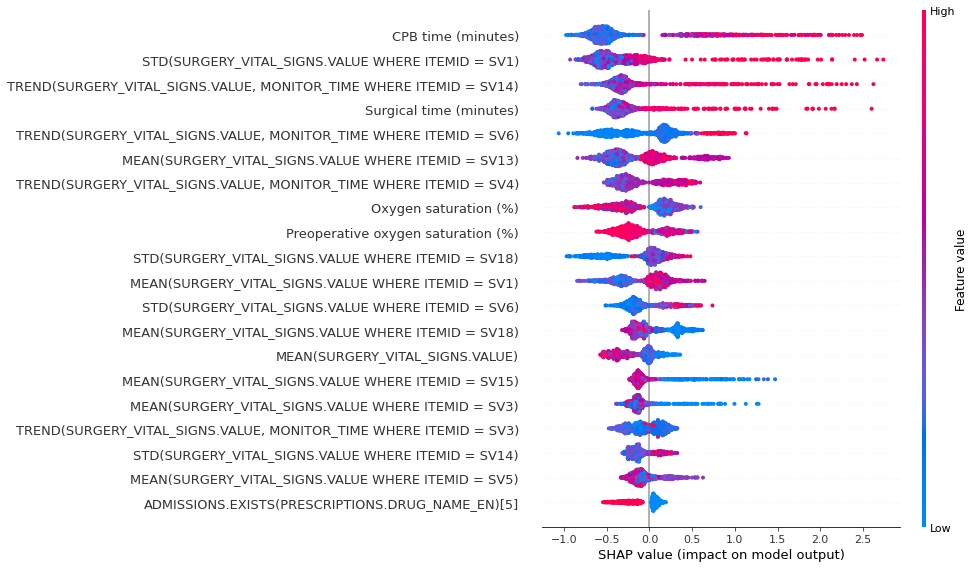

In [20]:
import shap
import matplotlib.pyplot as plt

# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, pd.DataFrame(X_train, columns=X.columns))

In [21]:
# Helper function for signal explanations

def visualize_signal(signal, c=None, vmin=None, vmax=None):
    plt.plot(np.arange(len(signal)), signal, c="black", zorder=1)
    plt.scatter(np.arange(len(signal)), signal, c=c, cmap="Reds_r", vmin=vmin, vmax=vmax, zorder=2)
    if c is not None:
        plt.colorbar()
        
def distribute_shap(shap_values, v):
    v_norm = v / sum(v)
    return shap_values * v_norm

In [22]:
# Helper functions to run occlusion algorithm

def occlude(signal, algorithm, start, size):
    # algorithm - one of:
    #    linear - linearly connect the window endpoints
    #    mean - fill with constant equal to window mean
    #    start - fill with constant equal to first endpoint
    #    mean_endpoints - fill with constant equal to mean of endpoints
    
    occluded = signal.copy()
    endpoint_1 = signal[start]
    if start+size-1 < len(signal):
        endpoint_2 =signal[start+size-1]
    else:
        endpoint_2 = signal[len(signal)-1]
        
    if algorithm == "linear":
        occluded[start:start+size] = np.linspace(endpoint_1, endpoint_2, len(occluded[start:start+size]))
        return occluded
            
    if algorithm == "mean":
        value = signal[start:start+size].mean()
        
    if algorithm == "start":
        value = signal[start]
        
    if algorithm == "mean_endpoints":
        value = (endpoint_1 + endpoint_2) / 2
    
    occluded[start:start+size] = value
    return occluded

def run_occlusion(signal, feature_algos, algorithm, window_size=10):
    base_values = []
    for algo in feature_algos:
        base_values.append(algo(signal))
    v = np.zeros((len(signal), len(feature_algos)))
    hits = np.zeros(len(signal))
    for start in range(len(signal)):
        occluded = occlude(signal, "linear", start, window_size)
        new_values = []
        for algo in feature_algos:
            new_values.append(algo(occluded))
        for i in range(len(base_values)):
            v[start:start+window_size, i] += ((base_values[i] - new_values[i]) / np.abs(base_values[i])) 
        hits[start:start+window_size] += 1

    v = v / hits.reshape(-1, 1)
    return v

def mean_contributions(signal):
    # Calculate the importance of each point to the mean
    mean = np.mean(signal)
    n = len(signal)
    new_means = np.array([(np.sum(signal) - x + mean) / n for x in signal])
    v = (mean - new_means) / (np.abs(mean))
    return v

In [23]:
# Constants for selecting which surgery/feature to explain

UNI_OPER_ID = 885705  # surgery ID of interest
FEATURE_NAME = "Pulse"
FEATURE_TABLE = "SURGERY_VITAL_SIGNS"

FEATURE_EXTRACTION_ALGOS = [np.mean, np.std]

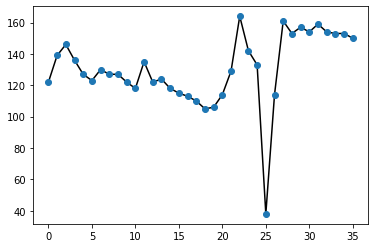

In [24]:
# EXTRACT THE SIGNAL OF INTEREST

feature_rows = es["D_ITEMS"].df.loc[es["D_ITEMS"].df["LABEL"] == FEATURE_NAME]
feature_code = feature_rows.loc[feature_rows["LINKSTO"].str.lower() == FEATURE_TABLE.lower()]["ITEMID"][0]

feature_table = es[FEATURE_TABLE].df
uni_oper_id_feature_table = feature_table.loc[feature_table["UNI_OPER_ID"] == UNI_OPER_ID]

feature_measures = uni_oper_id_feature_table.loc[uni_oper_id_feature_table["ITEMID"] == feature_code]
feature_measures.sort_values(by="MONITOR_TIME", axis="index", inplace=True)

feature_signal = feature_measures["VALUE"]

visualize_signal(feature_signal)

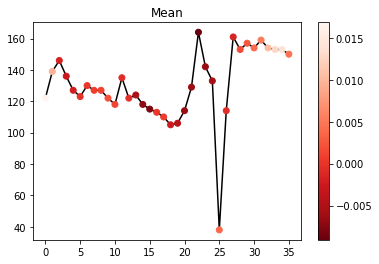

In [25]:
# Get the feature extraction importances of each signal point

v = run_occlusion(feature_signal.to_numpy(), FEATURE_EXTRACTION_ALGOS, "linear")
#v_mean = mean_contributions(feature_signal.to_numpy())

visualize_signal(feature_signal, c=v[:,0])
plt.title("Mean")
plt.show()

#visualize_signal(feature_signal, c=v[:,1], vmin=-.2, vmax=.2)
#plt.title("Std")

In [26]:
# Extract the relevant shap values

SHAP_BASE_NAME = "(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = %s)_x" % feature_code
SHAP_ALGO_NAMES = ["MEAN", "STD"]

feature_inds = [X.columns.get_loc(name + SHAP_BASE_NAME) for name in SHAP_ALGO_NAMES]

row_ind = np.where(train_index == UNI_OPER_ID)[0]
if len(row_ind) > 0:
    surgery_feature_shap_values = shap_values_train[:, feature_inds][row_ind[0]]
else:
    row_ind = np.where(test_index == UNI_OPER_ID)[0]
    surgery_feature_shap_values = shap_values_test[:, feature_inds][row_ind[0]]
    
weighted_shap = distribute_shap(surgery_feature_shap_values, np.abs(v))

visualize_signal(feature_signal, c=weighted_shap[:,0] + weighted_shap[:,1], vmin=-.03, vmax=0)
plt.title("Pulse Contribution")

KeyError: 'MEAN(SURGERY_VITAL_SIGNS.VALUE WHERE ITEMID = SV2)_x'